# Проект: классификация

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import optuna
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif, RFE

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [168]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [169]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df0=df.isnull().sum()
df0[df0>0]

balance    25
dtype: int64

### Задание 2

In [170]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [171]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [172]:
#df.balance=df.balance.fillna('0')
b=df[~df.balance.isna()].balance
b=b.map(lambda x: x.replace(' ', ''))
b=b.map(lambda x: x.replace(',00', '.'))
b=b.map(lambda x: x.replace('$', ''))
b=b.astype('float64')
df.balance=b


In [173]:
round(b.mean(), 3)

1529.129

### Задание 4

In [174]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.balance.fillna(df.balance.median(), inplace=True)
round(df.balance.mean(), 3)

1526.936

### Задание 5

In [175]:
top=df[['education', 'job']].mode().iloc[0]
top.job

'management'

In [176]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.job[df.job=='unknown']=df[df.job!='unknow'].job.mode()[0]
df['education'][df['education']=='unknown']=df[df['education']!='unknown']['education'].mode()[0]
top=df[['education', 'job']].mode().iloc[0]
mask=(df.job==top.job)&(df.education==top.education)
round(df[mask].balance.mean(),3)

1598.883

### Задание 6

Text(0.5, 1.0, 'boxplot')

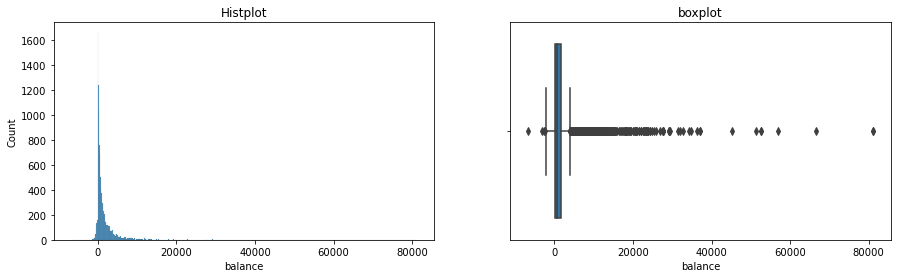

In [177]:
# удалите все выбросы для признака balance
fig, ax=plt.subplots(1,2,figsize=(15,4))
histplot=sns.histplot(data=df,x='balance', ax=ax[0])
histplot.set_title('Histplot')
boxplot=sns.boxplot(data=df, x='balance', ax=ax[1])
boxplot.set_title("boxplot")

In [178]:
x=df['balance']
q1, q3 = x.quantile(0.25), x.quantile(0.75)
iqr=q3-q1
lower_bound=q1-1.5*iqr
upper_bound=q3+1.5*iqr
print(f'lower_bound={lower_bound}, upper_bound={upper_bound}')
outlier=df[(x<lower_bound)|(x>upper_bound)]
df.drop(outlier.index, axis=0, inplace=True)


lower_bound=-2241.0, upper_bound=4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


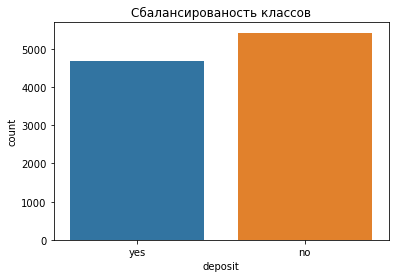

In [179]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(df.deposit.value_counts())#normalize=True))
ax=sns.countplot(df.deposit)
ax.set_title('Сбалансированость классов');

In [180]:
df.shape

(10105, 17)

### Задания 2 и 3

In [181]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.age.max()
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [182]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [183]:
df.groupby(by='poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [184]:
d1=df.groupby(by='deposit')['month'].value_counts(normalize=True)
d1
#df.pivot_table(values='balance', index='poutcome', columns='deposit', aggfunc='value_counts')

deposit  month
no       may      0.327434
         jul      0.154130
         aug      0.142883
         jun      0.111726
         nov      0.084071
         feb      0.059550
         apr      0.058444
         jan      0.035767
         oct      0.011431
         sep      0.008481
         mar      0.004425
         dec      0.001659
yes      may      0.179662
         aug      0.130314
         jul      0.124332
         apr      0.109592
         jun      0.106388
         feb      0.082461
         nov      0.069216
         oct      0.058321
         sep      0.049562
         mar      0.045503
         jan      0.026704
         dec      0.017945
Name: month, dtype: float64

### Задание 7

In [185]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
d=df.pivot_table(values='balance',
               index='month',
               columns='deposit',
               aggfunc=['count'])
d['count', 'rel']=d['count','no']/(d['count','yes']+d['count', 'no'])
d

count               
deposit    no  yes       rel
month                       
apr       317  513  0.381928
aug       775  610  0.559567
dec         9   84  0.096774
feb       323  386  0.455571
jan       194  125  0.608150
jul       836  582  0.589563
jun       606  498  0.548913
mar        24  213  0.101266
may      1776  841  0.678640
nov       456  324  0.584615
oct        62  273  0.185075
sep        46  232  0.165468

In [186]:
# вариантрешения 2
for index in np.unique(df.month):
    print(index, df[(df.month == index)&(df.deposit == 'no')].shape[0]/df[(df.month == index)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

0 <30
1 30-40
2 40-50
3 50-60


<AxesSubplot:xlabel='age_r', ylabel='Count'>

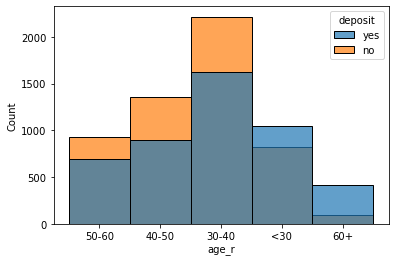

In [187]:

range_list=[0,30,40,50,60]
range_n=['<30', '30-40','40-50','50-60','60+']
df['age_r']=range_n[-1]
for i in range(len(range_list)-1):
    print(i, range_n[i])
    df.loc[(df['age']>range_list[i])&(df['age']<=range_list[i+1]),'age_r']=range_n[i]
sns.histplot(data=df,x='age_r', hue='deposit', alpha=0.7)
    


In [188]:
df['age_r1'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
bins = pd.IntervalIndex.from_tuples([(0, 30), (30, 40), (40, 50), (50,60), (60,150)])
df['age_r2']=pd.cut(df.age, bins)
df[['age_r', 'age_r1', 'age_r2']].value_counts()
#sns.histplot(data=df,x='age_r1', hue='deposit', alpha=0.9)

age_r  age_r1  age_r2   
30-40  30-40   (30, 40]     3842
40-50  40-50   (40, 50]     2255
<30    <30     (0, 30]      1870
50-60  50-60   (50, 60]     1625
60+    60+     (60, 150]     513
dtype: int64

### Задания 9 и 10

<AxesSubplot:xlabel='job', ylabel='Count'>

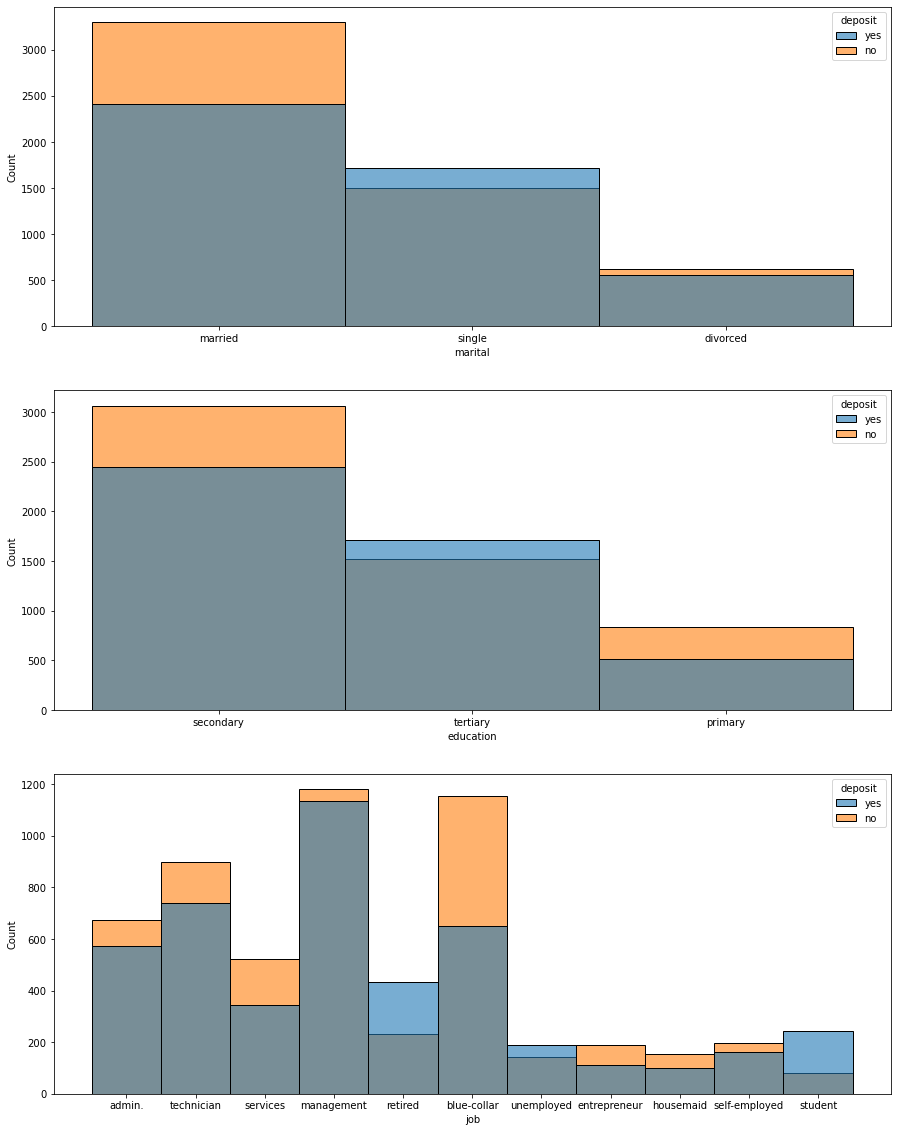

In [189]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, axes=plt.subplots(3,1,figsize=(15, 20))
sns.histplot(data=df, x='marital', hue='deposit', stat='count', alpha=0.6, ax=axes[0])
sns.histplot(data=df, x='education', hue='deposit', alpha=0.6, ax=axes[1])
sns.histplot(data=df, x='job', hue='deposit', stat='count', alpha=0.6, ax=axes[2])
#ax[1].set_title='Deposit- Marital'

In [190]:
fig=px.histogram(data_frame=df, x='job', color='deposit')
fig.show()

In [191]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [192]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [193]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_y, df_n = df[df['deposit']=='yes'], df[df['deposit']=='no']
df_y_c=df_y.pivot_table(
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'    
)
df_y_c1=pd.crosstab(df_y.education, df_y.marital)#аналог способа выше
df_n_c=df_n.pivot_table(
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='count'    
)

In [194]:
df_y_c

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [195]:
df_y_c1

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


<AxesSubplot:xlabel='marital', ylabel='education'>

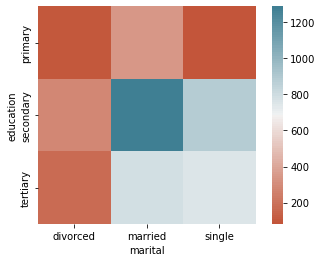

In [196]:
sns.heatmap(df_y_c, cmap=sns.diverging_palette(20, 220, n=100),square=True,)

In [197]:
df_n

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_r,age_r1,age_r2
5289,57,retired,single,primary,no,604.0,no,no,cellular,19,nov,187,1,-1,0,unknown,no,50-60,50-60,"(50, 60]"
5290,45,admin.,divorced,secondary,no,0.0,yes,no,cellular,17,nov,102,1,-1,0,unknown,no,40-50,40-50,"(40, 50]"
5291,48,blue-collar,married,secondary,no,238.0,yes,yes,cellular,2,jun,118,2,81,1,success,no,40-50,40-50,"(40, 50]"
5292,34,admin.,single,secondary,no,673.0,yes,no,cellular,29,jan,89,1,260,2,failure,no,30-40,30-40,"(30, 40]"
5294,32,management,married,tertiary,no,3696.0,no,no,unknown,21,may,315,3,-1,0,unknown,no,30-40,30-40,"(30, 40]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40,30-40,"(30, 40]"
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40,30-40,"(30, 40]"
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40,30-40,"(30, 40]"
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50,40-50,"(40, 50]"


<AxesSubplot:xlabel='marital', ylabel='education'>

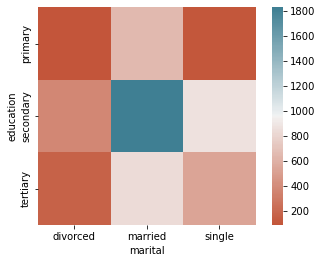

In [198]:
sns.heatmap(df_n_c, cmap=sns.diverging_palette(20, 220, n=200),square=True)

## Часть 3: преобразование данных

### Задание 1

In [199]:
# преобразуйте уровни образования
encoder=LabelEncoder
df['education']=encoder.fit_transform(encoder,df['education'])
df['education'].value_counts()

1    5517
2    3239
0    1349
Name: education, dtype: int64

In [200]:
encoder.classes_

array(['primary', 'secondary', 'tertiary'], dtype=object)

In [201]:
df['education'].sum()

11995

In [202]:
encoder=LabelEncoder
df['age_r']=LabelEncoder.fit_transform(encoder, df['age_r'])


In [203]:
df.drop([ 'age_r1', 'age_r2'], axis=1, inplace=True)

### Задания 2 и 3

In [204]:
# преобразуйте бинарные переменные в представление из нулей и единиц
for x in ['deposit', 'default', 'housing', 'loan']:
    df[x]=np.where(df[x]=='yes',1,0)

In [205]:
round(df['deposit'].std(),3)

0.499

In [206]:
df[['default', 'housing', 'loan']].mean().sum().round(3)

0.635

In [207]:
df=pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome' ])#, drop_first=True)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_r              10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задание 4

In [209]:
# создайте дамми-переменные
corr=df.corr()['deposit'].abs()#.sort_values()
corr.sort_values(ascending=False, inplace=True)

### Задания 5 и 6

<AxesSubplot:>

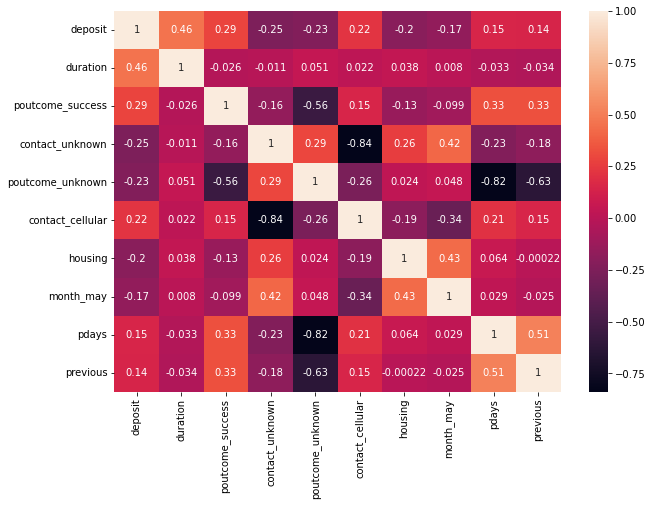

In [210]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax=plt.subplots(figsize=(10,7)) 
sns.heatmap(df[corr[:10].index].corr(), annot=True,ax=ax)#, cmap=sns.diverging_palette(20, 220, n=200),)

Text(0.5, 1.0, 'Correlation with deposit')

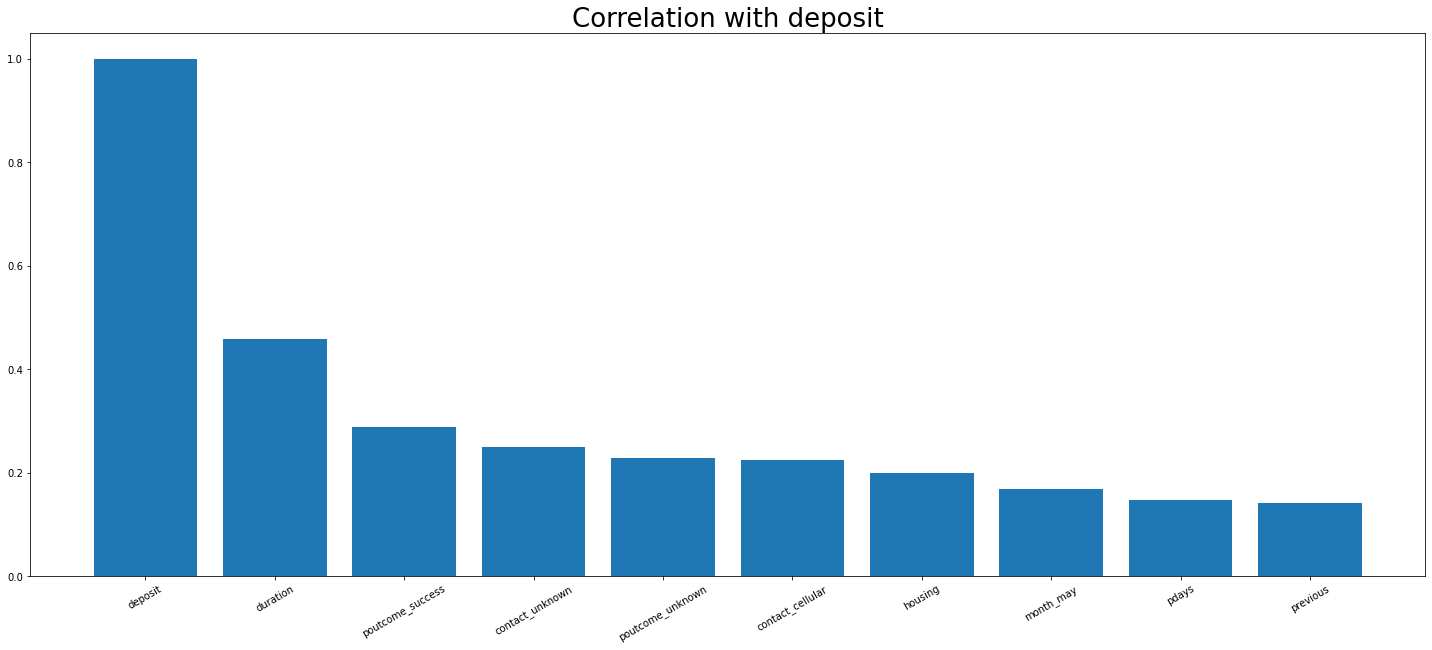

In [211]:
fig, ax=plt.subplots(1,1, figsize=(25,10))
ax.bar( x=corr[:10].index, height=corr[:10].values)
#ax.xaxis.set_tick_params
ax.xaxis.set_tick_params(rotation=30)
ax.set_title("Correlation with deposit", fontsize =26)

### Задания 7 и 8

In [212]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [213]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [214]:
round(y_test.mean(),2)

0.46

### Задание 9

In [215]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков\
sel=SelectKBest(f_classif, k=15)
sel.fit(X_train, y_train)
col=sel.get_feature_names_out()
X_train=X_train[col]
X_test=X_test[col]   
col
    

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_r', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [216]:
# нормализуйте данные с помощью minmaxsxaler
scaler=MinMaxScaler()
X_train_n=scaler.fit_transform(X_train)
X_train_n=pd.DataFrame(X_train_n, columns=X_train.columns)
X_test_n=scaler.transform(X_test)
X_test_n=pd.DataFrame(X_test_n, columns=X_test.columns)
round(X_test_n[X_test_n.columns[0]].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [217]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
lr.fit(X_train_n, y_train)
y_test_pr=lr.predict(X_test_n)
metrics.accuracy_score(y_test_pr, y_test).round(2)

0.81

### Задания 2,3,4

In [218]:
# обучите решающие деревья, настройте максимальную глубину
dt=tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt.fit(X_train_n, y_train)
y_train_pr=dt.predict(X_train_n)
print(metrics.accuracy_score(y_train, y_train_pr))
y_test_pr=dt.predict(X_test_n )
metrics.accuracy_score(y_test, y_test_pr)

1.0


0.7487256371814093

### Задание 5

In [219]:
# подберите оптимальные параметры с помощью gridsearch
dt.get_depth()

32

In [220]:
param_grid={'max_depth': list(range(1,50))}
grid_search=GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5
)
grid_search.fit(X_train_n, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [221]:
grid_search.score(X_test_n, y_test)

0.8068965517241379

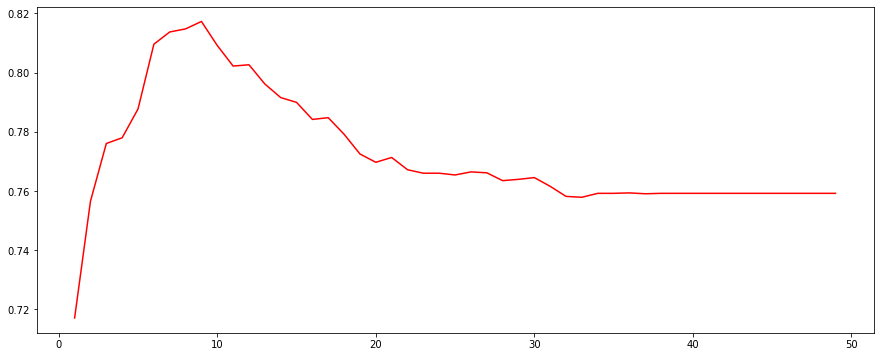

In [222]:
rez=grid_search.cv_results_
#rez_te=grid_search_te.cv_results_
#grid_search.fit()
fig, ax=plt.subplots(1,1, figsize=(15,6))
#ax.plot([1,2,3],[3,4,5])
ax.plot(np.array(range(1,50)), rez['mean_test_score'],label="Train", c='r')
#ax.plot(np.array(range(1,50)), rez_te['mean_test_score'],label="Test", c='g')
ax.grid=True

In [223]:
# обучите решающие деревья с лучшей глубиной

for i in range(3,10):
    
    # Создаём объект класса DecisionTreeClassifier
    dtree_clf = tree.DecisionTreeClassifier(
        criterion='entropy', # критерий информативности 
        max_depth=i, #максимальная глубина
        random_state=42 #генератор случайных чисел
    )
    # Обучаем дерево решений по алгоритму CART
    dtree_clf.fit(X_train_n, y_train)

    # Делаем предсказание классов:
    y_train_pred = dtree_clf.predict(X_train_n)
    y_test_pred = dtree_clf.predict(X_test_n)

    # Рассчитываем accuracy
    print(f'max_depth =', i)
    
    mas_train = metrics.accuracy_score(y_train, y_train_pred)
    mas_test = metrics.accuracy_score(y_test, y_test_pred)
    mas_delta = mas_train - mas_test
    print('Accuracy для train: {:.2f}'.format(mas_train))
    print('Accuracy для test: {:.2f}'.format(mas_test))
    print('Accuracy разница для train и test: {:.2f}'.format(mas_delta))

max_depth = 3
Accuracy для train: 0.78
Accuracy для test: 0.77
Accuracy разница для train и test: 0.01
max_depth = 4
Accuracy для train: 0.78
Accuracy для test: 0.77
Accuracy разница для train и test: 0.01
max_depth = 5
Accuracy для train: 0.80
Accuracy для test: 0.79
Accuracy разница для train и test: 0.01
max_depth = 6
Accuracy для train: 0.82
Accuracy для test: 0.81
Accuracy разница для train и test: 0.01
max_depth = 7
Accuracy для train: 0.84
Accuracy для test: 0.81
Accuracy разница для train и test: 0.02
max_depth = 8
Accuracy для train: 0.84
Accuracy для test: 0.81
Accuracy разница для train и test: 0.03
max_depth = 9
Accuracy для train: 0.85
Accuracy для test: 0.81
Accuracy разница для train и test: 0.04


In [224]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)

In [2]:
# Самая высокая точность QQпри минимальной дельта метрик тренировочной и обучающей выборки при глубине дераева равнойй 6

In [226]:
tree.DecisionTreeClassifier

sklearn.tree._classes.DecisionTreeClassifier

In [227]:
param_grid1={'min_samples_split':[2, 5, 7, 10],'max_depth':[3,5,7]}
grid_search1=GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid1,
    cv=5,
    scoring=('f1'),
    return_train_score=True
)
grid_search1.fit(X_train_n, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

In [228]:
grid_search1.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=7,
                       random_state=42)

In [229]:
grid_search1.best_score_

0.7979478025222647

In [230]:
grid_search1.score(X_test_n, y_test)

0.8035487959442332

In [231]:
y_pr_te=grid_search1.predict(X_test_n)
metrics.f1_score(y_test, y_pr_te)

0.8035487959442332

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [232]:
# обучите на ваших данных случайный лес
rf=ensemble.RandomForestClassifier(
        n_estimators = 100,
        criterion = 'entropy',
        min_samples_leaf = 5,
        max_depth = 6,
        random_state = 42)
rf.fit(X_train_n, y_train)
y_test_pr_rf=rf.predict(X_test_n)
print(f'recall={metrics.recall_score(y_test, y_test_pr_rf):.4f} accuracy={metrics.accuracy_score(y_test, y_test_pr_rf):.4f}')

recall=0.8214 accuracy=0.8228


### Задания 2 и 3

In [233]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb=ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42)
gb.fit(X_train_n, y_train)
y_test_pr_gb=gb.predict(X_test_n)
print(f'F1_score={metrics.f1_score(y_test, y_test_pr_gb):.2f}')

F1_score=0.82


In [234]:
print(metrics.classification_report(y_test, y_test_pr_gb, digits=4))

              precision    recall  f1-score   support

           0     0.8498    0.8218    0.8356      1790
           1     0.8011    0.8317    0.8161      1545

    accuracy                         0.8264      3335
   macro avg     0.8255    0.8268    0.8258      3335
weighted avg     0.8272    0.8264    0.8266      3335



In [235]:
print(metrics.classification_report(y_test, y_test_pr_rf, digits=4))

              precision    recall  f1-score   support

           0     0.8424    0.8240    0.8331      1790
           1     0.8011    0.8214    0.8111      1545

    accuracy                         0.8228      3335
   macro avg     0.8218    0.8227    0.8221      3335
weighted avg     0.8233    0.8228    0.8229      3335



### Задание 4

In [236]:
est = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

In [237]:
# объедините уже известные вам алгоритмы с помощью стекинга 
est1=[('dt',tree.DecisionTreeClassifier(criterion='entropy', random_state=42)),
     ('lr', linear_model.LogisticRegression(solver='sag', random_state=42)),
     ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42) )]

sc=ensemble.StackingClassifier(
    estimators=est,
    final_estimator=linear_model.LogisticRegression(random_state=42))
sc.fit(X_train_n, y_train)
y_test_pr_sc=sc.predict(X_test_n)
metrics.precision_score(y_test, y_test_pr_sc)

0.8099547511312217

### Задание 5

In [239]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42)
selector = RFE(estimator, n_features_to_select=3, step=0.1, verbose=2)
selector = selector.fit(X_train_n[['duration','contact_unknown','poutcome_success']], y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_

['duration' 'contact_unknown' 'poutcome_success']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_r', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([1, 1, 1])

In [240]:
selector.ranking_

array([1, 1, 1])

In [241]:
# sel=SelectKBest(f_classif, k=15)
#  sel.fit(X_train, y_train)
# col=sel.get_feature_names_out()
df_i=pd.DataFrame({'col':sel.feature_names_in_, 'score':sel.scores_})
mask=df_i['col'].isin(['duration', 'contact_unknown', 'poutcome_success'])
df_i[mask].sort_values(by='score', ascending=False)

,col,score
7,duration,1839.078214
43,poutcome_success,628.351616
28,contact_unknown,427.557659


### Задания 6,7,8

In [243]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
optuna.__version__

'2.10.1'

In [254]:
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    model=ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42)
    model.fit(X_train_n, y_train)
    score=metrics.f1_score(y_test, model.predict(X_test_n))
    return score

In [260]:
study=optuna.create_study(
    study_name='RandomForestClassifier',
    direction='maximize'
)
study.optimize(optuna_rf, 30)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
study.best_value

[I 2022-11-20 15:53:35,548] A new study created in memory with name: RandomForestClassifier
[I 2022-11-20 15:53:36,551] Trial 0 finished with value: 0.8149556400506971 and parameters: {'n_estimators': 102, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8149556400506971.
[I 2022-11-20 15:53:37,532] Trial 1 finished with value: 0.8197857592942659 and parameters: {'n_estimators': 126, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8197857592942659.
[I 2022-11-20 15:53:38,518] Trial 2 finished with value: 0.8201892744479495 and parameters: {'n_estimators': 109, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8201892744479495.
[I 2022-11-20 15:53:40,132] Trial 3 finished with value: 0.8225298930144745 and parameters: {'n_estimators': 175, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8225298930144745.
[I 2022-11-20 15:53:41,249] Trial 4 finished with value: 0.8170347003154574 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 167, 'max_depth': 21, 'min_samples_leaf': 3}


0.8230842005676442

In [261]:
model=ensemble.RandomForestClassifier(
    **study.best_params,
    random_state=42
)
model.fit(X_train_n, y_train)
y_test_pr=model.predict(X_test_n)
print(f' F1_score={metrics.f1_score(y_test, y_test_pr)}')

 F1_score=0.8230842005676442


In [263]:
metrics.accuracy_score(y_test, y_test_pr)

0.831784107946027

In [1]:
#Качество модели, после подбора гиперпараметров с помощью Optuna повысилось, HARAR